In [2]:
import os
import sys
import optuna


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from simulator.utils.load_data import load_md_from_file
from simulator.utils.get_info import get_pnl
from simulator.strategies.stoikov_avellaneda import StoikovAvellaneda
from simulator.strategies.symetrical import Symetrical
from simulator.simulator import Sim


PATH_TO_FILE = '../md/btcusdt_Binance_LinearPerpetual/'
NROWS = 1_000_000

md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = Sim(md, latency, md_latency)
# delay between orders
delay = pd.Timedelta(0.1, 's').delta

hold_time = pd.Timedelta(10, 's').delta


# strategy = Symetrical(delay, hold_time)
# strategy = StoikovAvellaneda(delay, hold_time, gamma=0.5, sigma=0.05,
#                              k=0.5, time_trading_session_ends=1655976252045000000)


C:\Users\igorl\AppData\Local\Temp\ipykernel_6016\747121749.py:24: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  latency = pd.Timedelta(10, 'ms').delta
C:\Users\igorl\AppData\Local\Temp\ipykernel_6016\747121749.py:25: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  md_latency = pd.Timedelta(10, 'ms').delta
C:\Users\igorl\AppData\Local\Temp\ipykernel_6016\747121749.py:29: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  delay = pd.Timedelta(0.1, 's').delta
C:\Users\igorl\AppData\Local\Temp\ipykernel_6016\747121749.py:31: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  hold_time = pd.Timedelta(10, 's').delta


In [3]:
def objective(trial):
    sim = Sim(md, latency, md_latency)

    gamma = trial.suggest_float('gamma', 0.0000001, 0.1)
    sigma = trial.suggest_float('sigma', 0, 0.2)
    k = trial.suggest_float('k', 0.0000001, 0.1)
    strategy = StoikovAvellaneda(
        delay,
        hold_time,
        gamma=gamma,
        sigma=sigma,
        k=k,
        time_trading_session_ends=md[-1].receive_ts,
        time_trading_session_starts=md[0].receive_ts
    )

    trades_list, md_list, updates_list, all_orders = strategy.run(sim)
    df = get_pnl(updates_list)

    return -df.total.sum()


In [5]:
study = optuna.create_study()
# study.optimize(objective, n_trials=1000)

# study.best_params

[I 2022-11-03 22:10:40,767] A new study created in memory with name: no-name-7b972e31-e7b3-43e6-b460-17ca44ca2925


In [5]:
study.best_params

{'gamma': 0.04069983912543654,
 'sigma': 0.028574677266288373,
 'k': 0.031706478400614996}

{'gamma': 0.04069983912543654,
 'sigma': 0.028574677266288373,
 'k': 0.031706478400614996}

In [ ]:

# Trial 71 finished with value: -94139342.21393743 and parameters: {'gamma': 0.0875180040071227, 'sigma': 0.11382020799722299, 'k': 0.012697625777652544}. Best is trial 71 with value: -94139342.21393743.

In [7]:
best_params = {
    'gamma': 0.04069983912543654,
    'sigma': 0.028574677266288373,
    'k': 0.031706478400614996
}

sim = Sim(md, latency, md_latency)

strategy = StoikovAvellaneda(
    delay,
    hold_time,
    **best_params,
    time_trading_session_ends=md[-1].receive_ts,
    time_trading_session_starts=md[0].receive_ts
)

trades_list, md_list, updates_list, all_orders = strategy.run(sim)
df = get_pnl(updates_list)
dt = pd.to_datetime(df.receive_ts)

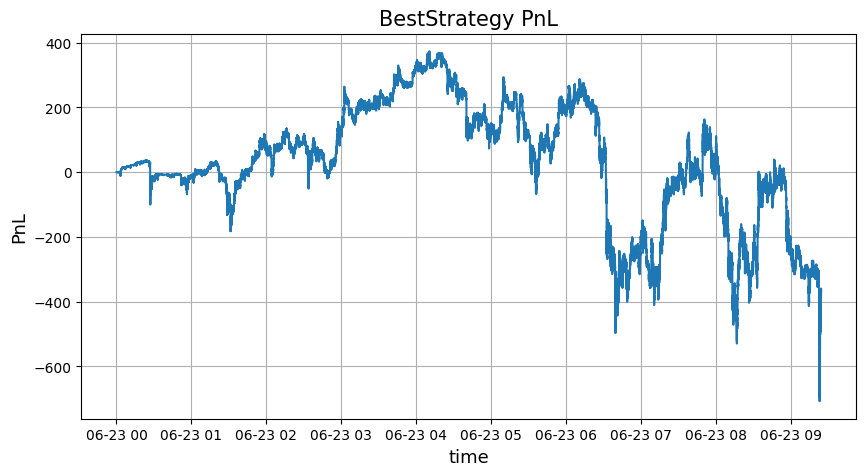

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("BestStrategy PnL", fontsize=15)
plt.grid()
plt.show()

In [9]:
df.total.sum()

108121559.15088014